In [20]:
# @title Import & Dataset initialize section
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset (download first or use URL)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

# Preview the data
print(df.head())
print(df.info())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

# Designing Naural Network using Pytorch

A Neural Network consists of three main components: the Input Layer, Hidden Layer, and Output Layer.

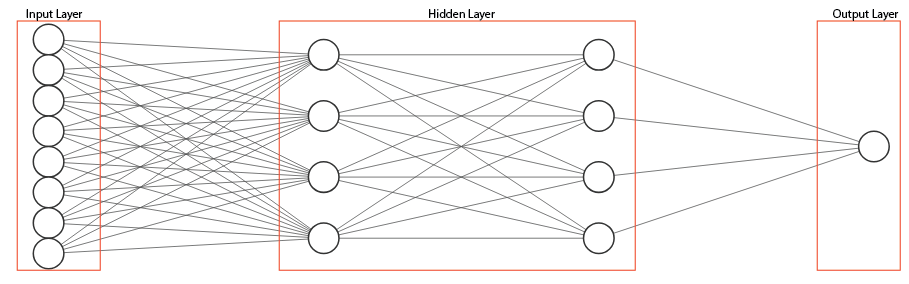

In [21]:
df['quality'] = (df['quality'] >= 6).astype(int)

# Split features and target
X = df.drop(columns=['quality'])
y = df['quality']

Normally input layers is 1D tensor which are feature of dataset or image flatten to 1D.

In this case we use all column except quality as the input feature.

In [22]:
print(X.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


So we have these features as the input.

     ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

that make 11 node as our input data.

Let's take a look at our target.

In [23]:
y.describe()

count    1599.000000
mean        0.534709
std         0.498950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: quality, dtype: float64

We see that output value is either 0 or 1 that mean we are makeing Binary Classification Model.

To determine number of output node we need to know type of model.

Multi-Class Classification Model need 1 output node for each class to represent the probabilty of input being that class.

In Binary Classification Model there is only yes or no. We can use either 1 output node (representing the probability that the result is positive if the probability is < 0.5, it means the result is negative, otherwise positive) or 2 output nodes (dedicating one node for negative probability and the other for positive probability).

In this case let say we use 1 output node.

### Neural Network Model

Let say we use 5 node in our single hidden layer.

We will get neural network model that look like this.

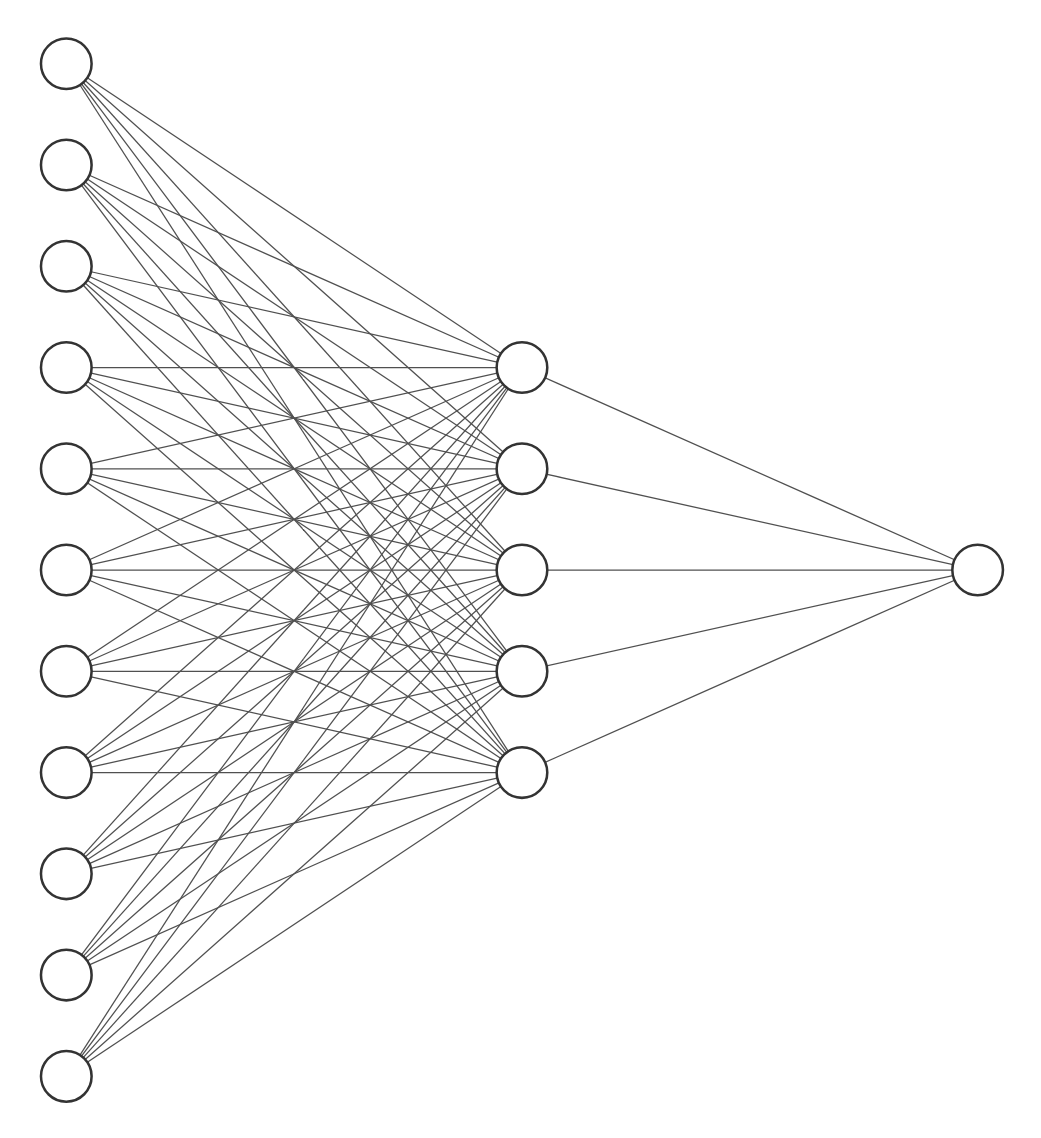

If we look inside the working process of Neural Network we will get this

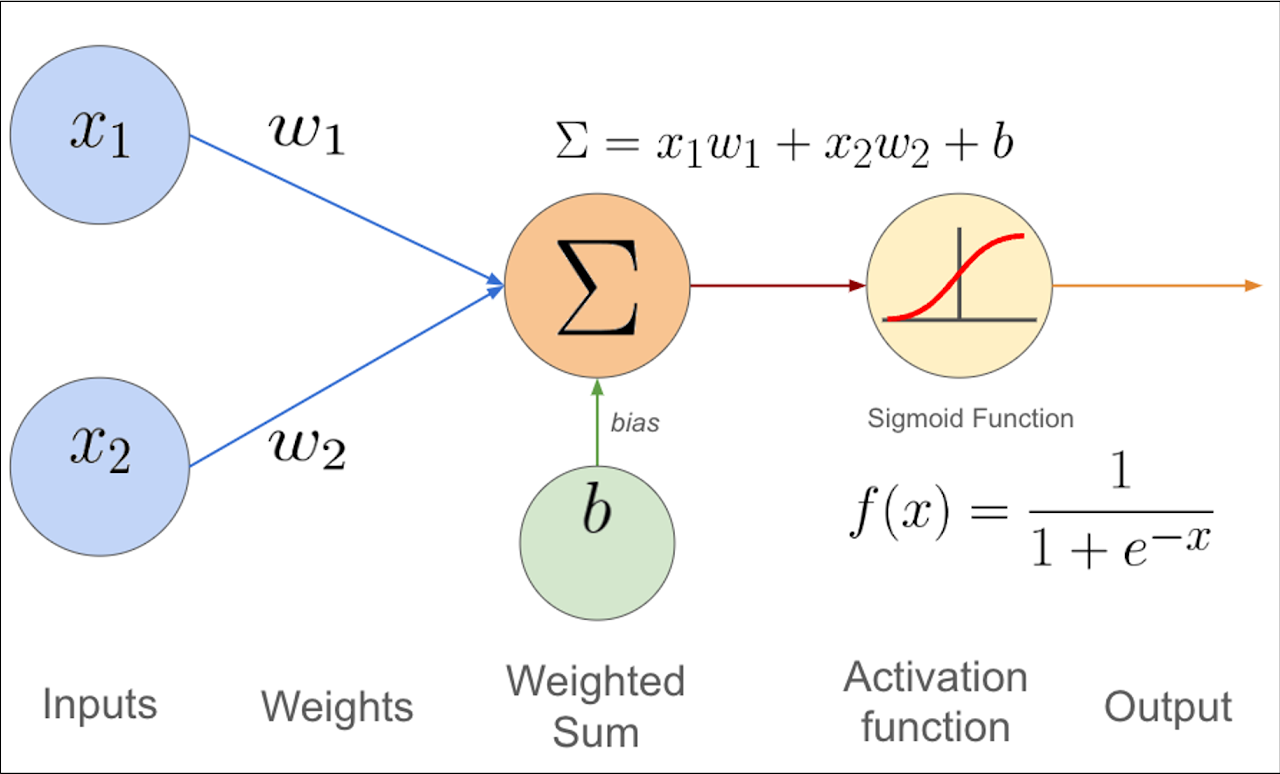

The input will be in shape of 1 x X and the weight will be in shape of X x Y with X as the number of input and Y as the number of output in that layer

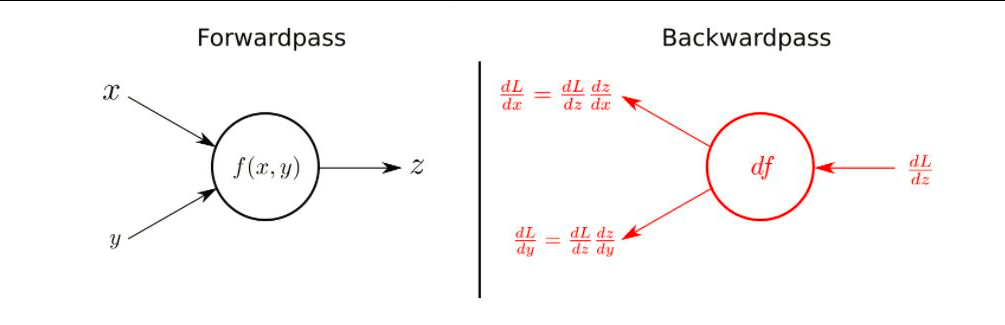

Backward propagation is used during the training phase of a model.
It calculates the loss using a loss function, which takes the actual results and the predicted results as inputs.

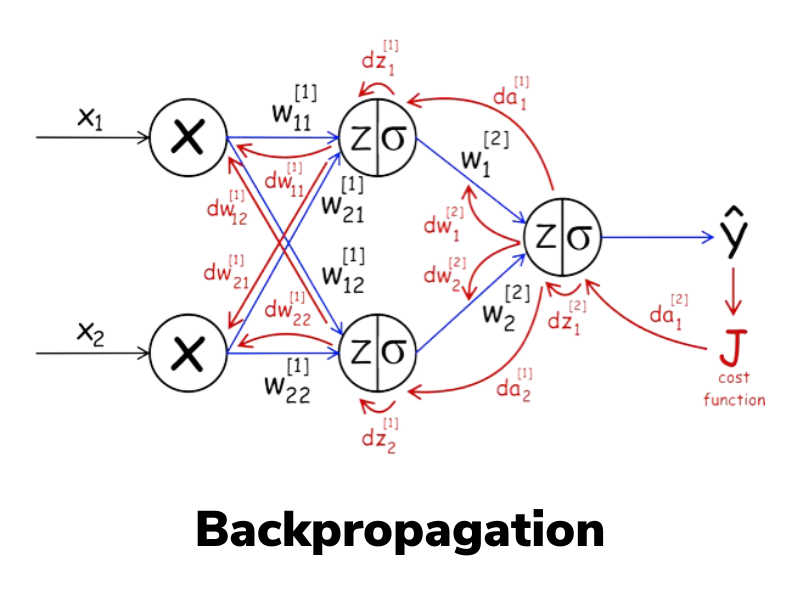

The computed loss is then propagated backward through all the hidden layers, applying gradient descent to update the model's parameters.

# NN From Scratch

In [24]:
import numpy as np

class Neuron:
    def __init__(self, input_dim, output_dim, activation=None):
        self.W = np.random.randn(input_dim, output_dim) # Generate weight with shape INPUT x OUTPUT (in this case 11 x 5 for the first part and 5 x 2 for the second part)
        self.b = np.random.randn(1, output_dim) # Generate bias in the same shape as the output
        self.activation = activation

    def forward(self, X):
        self.X = X
        self.Z = np.dot(X, self.W) # Input(1 x X) • Weight (X x Y) => Output (1 x Y)
        self.Z += self.b # Add bias to the output
        # Pass the output to the activation function if we have it
        if self.activation:
            self.A = self.activation.forward(self.Z)
        else:
            self.A = self.Z
        return self.A

    def backward(self, dA):
        # Calculate gradient according to loss received by backward propagation
        if self.activation:
            dZ = self.activation.backward(self.Z, dA)
        else:
            dZ = dA
        dW = np.dot(self.X.T, dZ)
        db = np.sum(dZ, axis=0, keepdims=True)
        dX = np.dot(dZ, self.W.T)
        return dW, db, dX

class Model:
    def __init__(self, layers_dim, activations):
        self.layers = []
        input_dim = layers_dim[0]
        for output_dim, activation in zip(layers_dim[:-1], activations[:-1]):
            self.layers.append(Neuron(input_dim, output_dim, activation=activation))
            input_dim = output_dim
        self.layers.append(Neuron(input_dim, layers_dim[-1], activation=activations[-1]))  # Last layer activation
        self.loss = []

    def calculate_loss(self, X, y):
        # Calculate loss from true result compare the the predicted value
        mse_loss = np.mean((self.predict(X) - y) ** 2)
        return mse_loss

    def predict(self, X):
        # Pass the input into hidden layers and propagate forward in neural network
        input = X
        for layer in self.layers:
            input = layer.forward(input)
        # the result here is passed through all the hidden layers
        return input

    def train(self, X, y, num_passes=20000, learning_rate=0.01, print_loss=False):
        for epoch in range(num_passes):
            # Forward propagation
            input = X
            for layer in self.layers:
                input = layer.forward(input)

            # Calculate the loss (Mean Squared Error)
            loss = np.mean((input - y) ** 2)
            self.loss.append(loss)

            # Back propagation
            dA = 2 * (input - y) / y.size
            for layer in reversed(self.layers):
                dW, db, dA = layer.backward(dA)
                layer.W -= learning_rate * dW
                layer.b -= learning_rate * db

            if print_loss and epoch % 1000 == 0:
                print(f"Loss after iteration {epoch}: {loss:.6f}")

# Activation functions
class ReLU:
    @staticmethod
    def forward(Z):
        return np.maximum(0, Z)

    @staticmethod
    def backward(Z, dA):
        return dA * (Z > 0)

class Sigmoid:
    @staticmethod
    def forward(Z):
        return 1 / (1 + np.exp(-Z))

    @staticmethod
    def backward(Z, dA):
        A = Sigmoid.forward(Z)
        return dA * A * (1 - A)

In [25]:
# Using it in our architecture 11 -> 5 -> 2
layers_dim = [11, 5, 2]  # Input size: 11, Hidden layer: 5 neurons, Output size: 2
activations = [ReLU(), None]

# We will initialize the starting weight and bias with np.random.
# That mean each time we run this code that value will be different if we dont use np.random.seed(X) to set the randowm seed

# Split into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Use long for classification
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create the model
model = Model(layers_dim, activations)

y_train_one_hot = np.zeros((y_train.size, 2), dtype=int)
y_train_one_hot[np.arange(y_train.size), y_train] = 1

# Train the model
# Learning rate will be how fast our model will learn the dataset
# Larger learning rate will cause overfitting otherwise smaller learning rate will cause underfitting instead
model.train(X_train, y_train_one_hot, num_passes=5000, learning_rate=0.0001, print_loss=True)

Loss after iteration 0: 6832.866293
Loss after iteration 1000: 0.372761
Loss after iteration 2000: 0.292143
Loss after iteration 3000: 0.277108
Loss after iteration 4000: 0.271128


# NN From Pytorch API

In [26]:
# Let use model import from Pytorch instead of our from scratch model
import torch.nn as nn

# Single-Layer Perceptron
class WineQuality_NN_SLP(nn.Module):
    def __init__(self, input_dim):
        super(WineQuality_NN_SLP, self).__init__()
        # in this model there no hidden layer so neuron in model will be 11 -> 2
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 2),
        )
    def forward(self, x):
        return self.layers(x)

# Multi-Layer Perceptron
class WineQuality_NN_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(WineQuality_NN_MLP, self).__init__()
        # in this model there one hidden layer so neuron in model will be 11 -> X -> 2 with X as the number of hidden layers we input
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # Binary classification: 2 output classes
        )
    def forward(self, x):
        return self.layers(x)


In [27]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

model_type = 'mlp'
# Hyperparameters
lr = 0.001
batch_size = 32
epochs = 500

# Define model
input_dim = X_train_tensor.shape[1]
hidden_dim = 5 # again follow our earlier architecture using 5 nueron in the hidden layers
model = WineQuality_NN_MLP(input_dim, hidden_dim) if model_type == 'mlp' else WineQuality_NN_SLP(input_dim)

# Dataloaders
# When we use pytorch, it is best to use dataloader to feed the model data instead of doing it manually
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Binary classification, softmax used internally
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
avg_train_acc = 0
avg_val_acc = 0

# Begin training loop
for epoch in range(epochs):
    model.train()
    train_acc = 0
    epoch_train_loss = 0

    # Train in batches
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y) # Calculate loss
        optimizer.zero_grad()
        loss.backward() # Apply gradient via backward propagation
        optimizer.step()
        epoch_train_loss += loss.item()
        # Training accuracy calculation within the training loop
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == batch_y).sum().item()

    avg_train_loss = epoch_train_loss / len(train_dataset)
    avg_train_acc = train_acc / len(train_dataset)
    # Average training loss and accuracy for the epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validate accuracy
    model.eval()
    val_acc = 0
    epoch_val_loss = 0
    for batch_val_X, batch_val_y in val_loader:
        with torch.no_grad():
            val_outputs = model(batch_val_X)
            loss = criterion(val_outputs, batch_val_y)
            epoch_val_loss += loss.item()
            # Training accuracy calculation
            _, predicted = torch.max(val_outputs, 1)
            val_acc += (predicted == batch_val_y).sum().item()

    avg_val_acc = val_acc / len(val_dataset)
    avg_val_loss = epoch_val_loss / len(val_dataset)
    # Average training loss and accuracy for the epoch
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Loss (train/val): {avg_train_loss:.4f}/{avg_val_loss:.4f}, Accuracy (train/val): {avg_train_acc:.4f}/{avg_val_acc:.4f}")

Epoch 1/500, Loss (train/val): 0.0219/0.0216, Accuracy (train/val): 0.5293/0.5594
Epoch 2/500, Loss (train/val): 0.0219/0.0216, Accuracy (train/val): 0.5293/0.5594
Epoch 3/500, Loss (train/val): 0.0218/0.0216, Accuracy (train/val): 0.5293/0.5594
Epoch 4/500, Loss (train/val): 0.0218/0.0216, Accuracy (train/val): 0.5293/0.5594
Epoch 5/500, Loss (train/val): 0.0218/0.0215, Accuracy (train/val): 0.5301/0.5563
Epoch 6/500, Loss (train/val): 0.0217/0.0215, Accuracy (train/val): 0.5301/0.5563
Epoch 7/500, Loss (train/val): 0.0217/0.0215, Accuracy (train/val): 0.5309/0.5563
Epoch 8/500, Loss (train/val): 0.0217/0.0214, Accuracy (train/val): 0.5324/0.5563
Epoch 9/500, Loss (train/val): 0.0216/0.0214, Accuracy (train/val): 0.5348/0.5531
Epoch 10/500, Loss (train/val): 0.0216/0.0214, Accuracy (train/val): 0.5364/0.5500
Epoch 11/500, Loss (train/val): 0.0216/0.0214, Accuracy (train/val): 0.5348/0.5500
Epoch 12/500, Loss (train/val): 0.0215/0.0213, Accuracy (train/val): 0.5340/0.5500
Epoch 13/500,

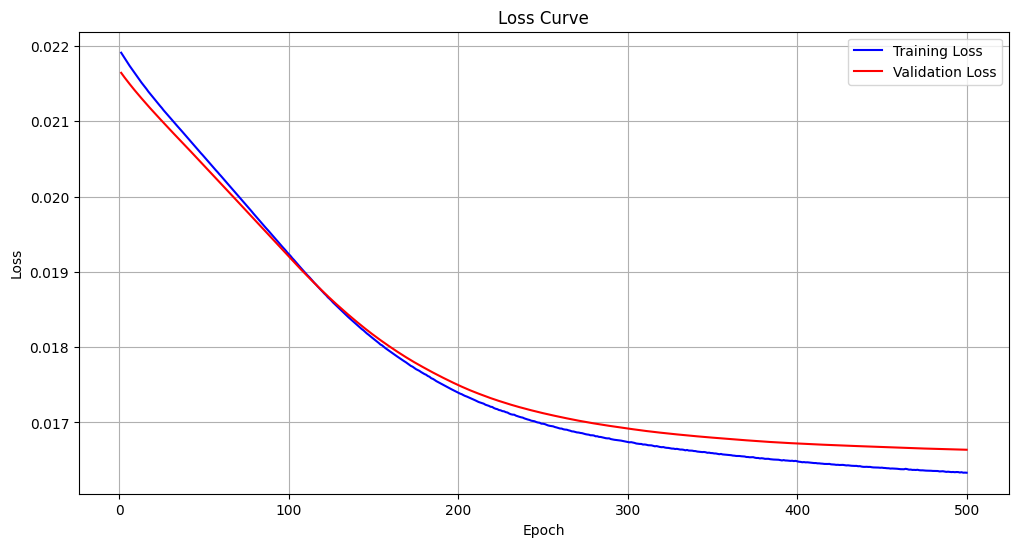

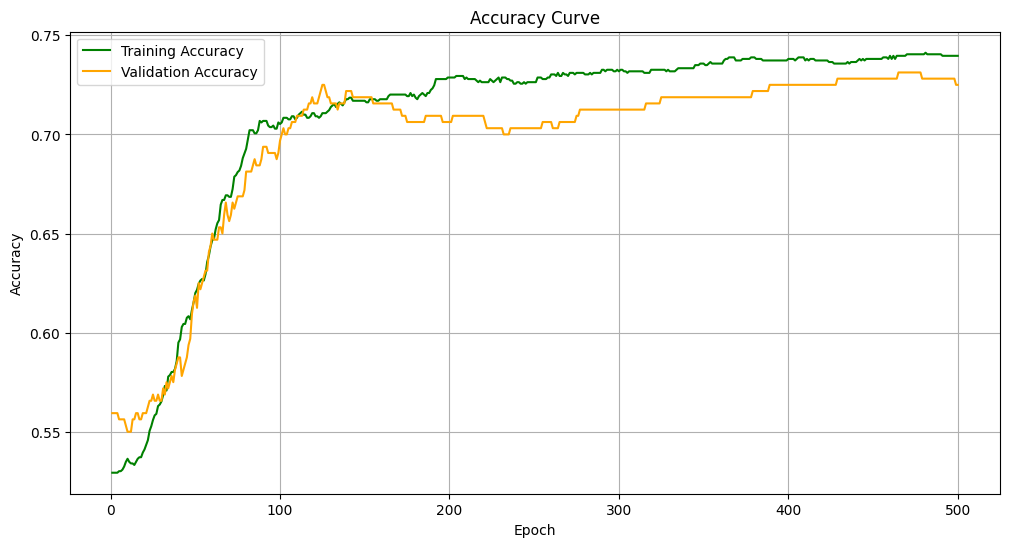

In [28]:
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(12, 6))

epochs_list = list(range(1, epochs + 1)) # Corrected to start from 1

# Plot loss
plt.plot(epochs_list, train_losses, label="Training Loss", color="blue")
plt.plot(epochs_list, val_losses, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()

# Create another figure for accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.plot(epochs_list, train_accuracies, label="Training Accuracy", color="green")
plt.plot(epochs_list, val_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()

plt.show()


# Problem with gradient descent

## Vanishing Gradient

Vanishing gradient is the problem which will surface when working with deeper (many hidden layers) model.

It occur when the the model is performing gradient descent, and the value of the gradient becomes smaller each time it passes to the next layer untill the gradient become 0.

Which mean the neuron in the early layer will not adjust their weight and bias regardless of real result causing model accuracy to stop improving.

In [29]:
# Example model
import torch.nn as nn
class DeepNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DeepNet, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.Sigmoid())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [30]:
# Example Vanishing Gradient
import torch.optim as optim
import torch

torch.manual_seed(42)
X = torch.randn(1000, 2)  # 2 features
y = torch.sigmoid(torch.sum(X, dim=1, keepdim=True))  # Simulated result using sigmoid function

model = DeepNet(2, 64, 20, 2) # <-- Many hidden layers
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

num_epochs = 500
losses = []
for epoch in range(num_epochs):
    y_pred = model(X)
    loss = criterion(y_pred, y) # Calculate loss
    optimizer.zero_grad()
    loss.backward() # Apply gradient via backward propagation
    optimizer.step()

    # Store and print loss
    losses.append(loss.item())
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.6f}")
        print("\nGradient magnitudes in the layers:")
        for i, layer in enumerate(model.net):
            if isinstance(layer, nn.Linear):  # Only check gradients in Linear layers
                print(f"Layer {i}: {layer.weight.grad.abs().mean():.10f}")

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0/500, Loss: 0.233652

Gradient magnitudes in the layers:
Layer 0: 0.0000000000
Layer 2: 0.0000000000
Layer 4: 0.0000000000
Layer 6: 0.0000000000
Layer 8: 0.0000000000
Layer 10: 0.0000000000
Layer 12: 0.0000000000
Layer 14: 0.0000000000
Layer 16: 0.0000000000
Layer 18: 0.0000000000
Layer 20: 0.0000000001
Layer 22: 0.0000000009
Layer 24: 0.0000000053
Layer 26: 0.0000000384
Layer 28: 0.0000002762
Layer 30: 0.0000018229
Layer 32: 0.0000134619
Layer 34: 0.0000822772
Layer 36: 0.0005572239
Layer 38: 0.0041162781
Layer 40: 0.2029819638
Epoch 50/500, Loss: 0.096702

Gradient magnitudes in the layers:
Layer 0: 0.0000000000
Layer 2: 0.0000000000
Layer 4: 0.0000000000
Layer 6: 0.0000000000
Layer 8: 0.0000000000
Layer 10: 0.0000000000
Layer 12: 0.0000000000
Layer 14: 0.0000000000
Layer 16: 0.0000000000
Layer 18: 0.0000000000
Layer 20: 0.0000000000
Layer 22: 0.0000000004
Layer 24: 0.0000000022
Layer 26: 0.0000000162
Layer 28: 0.0000001115
Layer 30: 0.0000007536
Layer 32: 0.0000058492
Layer 3

## Exploding gradient

Exploding gradient happen when the initialize weight of neuron is too large meaning the gradient will grow larger when passing to the next layer via backward propagation.

In this case we will not change the value of the weight but we will use large learning rate causing gradient to explode.

In [31]:
# Example Exploding gradient
torch.manual_seed(42)
X = torch.randn(1000, 2)  # 2 features
y = torch.sigmoid(torch.sum(X, dim=1, keepdim=True))  # Simulated result using sigmoid function

model = DeepNet(2, 64, 20, 2)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=5) # <-- Large lr

num_epochs = 500
losses = []
for epoch in range(num_epochs):
    y_pred = model(X)
    loss = criterion(y_pred, y) # Calculate loss
    optimizer.zero_grad()
    loss.backward() # Apply gradient via backward propagation
    optimizer.step()

    # Store and print loss
    losses.append(loss.item())
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.6f}")
        print("\nGradient magnitudes in the layers:")
        for i, layer in enumerate(model.net):
            if isinstance(layer, nn.Linear):  # Only check gradients in Linear layers
                print(f"Layer {i}: {layer.weight.grad.abs().mean():.10f}")

Epoch 0/500, Loss: 0.233652

Gradient magnitudes in the layers:
Layer 0: 0.0000000000
Layer 2: 0.0000000000
Layer 4: 0.0000000000
Layer 6: 0.0000000000
Layer 8: 0.0000000000
Layer 10: 0.0000000000
Layer 12: 0.0000000000
Layer 14: 0.0000000000
Layer 16: 0.0000000000
Layer 18: 0.0000000000
Layer 20: 0.0000000001
Layer 22: 0.0000000009
Layer 24: 0.0000000053
Layer 26: 0.0000000384
Layer 28: 0.0000002762
Layer 30: 0.0000018229
Layer 32: 0.0000134619
Layer 34: 0.0000822772
Layer 36: 0.0005572239
Layer 38: 0.0041162781
Layer 40: 0.2029819638
Epoch 50/500, Loss: inf

Gradient magnitudes in the layers:
Layer 0: 0.0000000000
Layer 2: 0.0000000000
Layer 4: 0.0000000000
Layer 6: 0.0000000000
Layer 8: 0.0000000000
Layer 10: 0.0000000000
Layer 12: 0.0000000000
Layer 14: 0.0000000000
Layer 16: 0.0000000000
Layer 18: 0.0000000000
Layer 20: 0.0000000000
Layer 22: 0.0000000000
Layer 24: 0.0000000000
Layer 26: 0.0000000000
Layer 28: 0.0000000000
Layer 30: 0.0000000000
Layer 32: 0.0000000000
Layer 34: 0.

We will see that the gradient value keep getting larger untill it become nan after when we do any math operation with nan value it will result in 0 or nan meaning the model will stop learning

# How can we fix it?

In [32]:
import torch
import math

# Generate random inputs
x = torch.randn(100, 100)  # Simulate input activations

# Initialize weights using Kaiming Initialization
# This scales weights by sqrt(1 / input_size) to "stabilize" variance
w = torch.randn(100, 100) * math.sqrt(1. / 100.)

# Check mean and standard deviation of inputs and weights
print("Input Mean and Std Dev:", x.mean().item(), x.std().item())
print("Weight Mean and Standard:", w.mean().item(), w.std().item())



Input Mean and Std Dev: 0.007925515063107014 0.9987353086471558
Weight Mean and Standard: 0.0013075009919703007 0.09980347752571106


We see standard deviation of the initial weight is much smaller that the one we generate in input X that mean most of the initial weight will be around the mean value and there are less weight which are too large (x > 1.0 || X < -1.0) or too small (-0.1 > X > 0.1)

In [33]:
for i in range(50):
    x = x @ w
    print(f"Layer {i + 1}: Mean: {x.mean().item()}, Std Dev: {x.std().item()}")

Layer 1: Mean: -0.0006268408033065498, Std Dev: 1.0143823623657227
Layer 2: Mean: -0.0037648037541657686, Std Dev: 1.010300874710083
Layer 3: Mean: -0.009467655792832375, Std Dev: 1.029442548751831
Layer 4: Mean: -0.0031212028115987778, Std Dev: 1.0435906648635864
Layer 5: Mean: -0.0009853615192696452, Std Dev: 1.0426961183547974
Layer 6: Mean: -0.0031374029349535704, Std Dev: 1.0482109785079956
Layer 7: Mean: -0.0007032423163764179, Std Dev: 1.0406132936477661
Layer 8: Mean: -0.013485127128660679, Std Dev: 1.0482581853866577
Layer 9: Mean: -0.020692044869065285, Std Dev: 1.0386154651641846
Layer 10: Mean: -0.012738981284201145, Std Dev: 1.0049448013305664
Layer 11: Mean: 0.002507941098883748, Std Dev: 0.963845431804657
Layer 12: Mean: 0.007695481646806002, Std Dev: 0.9181169271469116
Layer 13: Mean: -0.0011364567326381803, Std Dev: 0.9039315581321716
Layer 14: Mean: 0.007372846826910973, Std Dev: 0.8814859986305237
Layer 15: Mean: -0.00815488025546074, Std Dev: 0.8739259243011475
Laye

We can see that the gradient is stable now

In [34]:
# And then there's second way which we can use to limit the value of gradient by using ReLu activation function
gain = math.sqrt(2.)
x = torch.randn(100, 100)
a = torch.randn(100, 100) * math.sqrt(1./100.) * gain # Apply Kaiming + ReLu

In [35]:
def relu(x):
    return x.clamp_(0.).sub_(0.5) # we clamp the value of x to be equal or greater that 0 and then we -0.5 for move mean downward to reduce computing cost (the gradient will be the value near 0)

In [36]:
for i in range(50):
    x = x @ a
    relu(x)
    print(f'{i}, {x.mean()}, {x.std()}')

0, 0.07104525715112686, 0.8371595740318298
1, -0.027107778936624527, 0.7014178037643433
2, -0.11911672353744507, 0.5837991237640381
3, -0.1879960298538208, 0.47705742716789246
4, -0.23980209231376648, 0.40976041555404663
5, -0.26363980770111084, 0.3702540695667267
6, -0.2735162377357483, 0.3496023118495941
7, -0.2723938822746277, 0.3538353741168976
8, -0.26854604482650757, 0.3585185110569
9, -0.2640933096408844, 0.3665176331996918
10, -0.25685450434684753, 0.3735981285572052
11, -0.2516632676124573, 0.38301047682762146
12, -0.24401645362377167, 0.3937884271144867
13, -0.23565185070037842, 0.4043850898742676
14, -0.23026135563850403, 0.4130842089653015
15, -0.22424443066120148, 0.4248163402080536
16, -0.21606040000915527, 0.4353705942630768
17, -0.21255098283290863, 0.4474516212940216
18, -0.20548632740974426, 0.45810961723327637
19, -0.1992974430322647, 0.4694761037826538
20, -0.19315986335277557, 0.47922152280807495
21, -0.1865362823009491, 0.4886413812637329
22, -0.18032878637313843,

The gradient mean is now 0 and the standard deviation are around 0.5 - 1

Solving vanishing gradient via rectified linear unit acitvation function

In [37]:
# Solving vanishing Gradient

# Example model
import torch.nn as nn
class DeepNet_relu(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DeepNet_relu, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

torch.manual_seed(42)
X = torch.randn(1000, 2)  # 2 features
y = torch.sigmoid(torch.sum(X, dim=1, keepdim=True))  # Simulated result using sigmoid function

model = DeepNet_relu(2, 64, 20, 2) # <-- Many hidden layers
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

num_epochs = 500
losses = []
for epoch in range(num_epochs):
    y_pred = model(X)
    loss = criterion(y_pred, y) # Calculate loss
    optimizer.zero_grad()
    loss.backward() # Apply gradient via backward propagation
    optimizer.step()

    # Store and print loss
    losses.append(loss.item())
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.6f}")
        print("\nGradient magnitudes in the layers:")
        for i, layer in enumerate(model.net):
            if isinstance(layer, nn.Linear):  # Only check gradients in Linear layers
                print(f"Layer {i}: {layer.weight.grad.abs().mean():.10f}")

Epoch 0/500, Loss: 0.360890

Gradient magnitudes in the layers:
Layer 0: 0.0000000006
Layer 2: 0.0000000007
Layer 4: 0.0000000008
Layer 6: 0.0000000011
Layer 8: 0.0000000018
Layer 10: 0.0000000042
Layer 12: 0.0000000161
Layer 14: 0.0000000312
Layer 16: 0.0000000650
Layer 18: 0.0000001508
Layer 20: 0.0000003170
Layer 22: 0.0000005335
Layer 24: 0.0000019173
Layer 26: 0.0000031868
Layer 28: 0.0000069747
Layer 30: 0.0000263385
Layer 32: 0.0000799861
Layer 34: 0.0001710100
Layer 36: 0.0002939801
Layer 38: 0.0008078780
Layer 40: 0.0172718205
Epoch 50/500, Loss: 0.321391

Gradient magnitudes in the layers:
Layer 0: 0.0000000006
Layer 2: 0.0000000007
Layer 4: 0.0000000007
Layer 6: 0.0000000011
Layer 8: 0.0000000017
Layer 10: 0.0000000041
Layer 12: 0.0000000155
Layer 14: 0.0000000304
Layer 16: 0.0000000623
Layer 18: 0.0000001436
Layer 20: 0.0000003034
Layer 22: 0.0000005079
Layer 24: 0.0000018256
Layer 26: 0.0000030445
Layer 28: 0.0000066621
Layer 30: 0.0000251052
Layer 32: 0.0000760205
Layer 3

# Homework

นายไซน์ มีข้อมูลอยู่ชุดหนึ่งที่สร้างจาก Function ที่เขาสนใจ แต่ข้อมูลนั้นดันมี noise ปะปนอยู่ด้วย ทำให้เขาไม่สามารถนำข้อมูลที่มีมาวาดเป็นกราฟเส้นได้ชัดเจน ดังภาพด้านล่าง

นายไซน์ ต้องการจะใช้ Neural networks มาเพื่อประมาณค่าข้อมูลที่มี แล้ววาดกราฟให้ได้มีความใกล้เคียงกับข้อมูลเดิมจาก Function ที่เขาสนใจมากที่สุด

จงสร้าง Neural Network Model ที่มีโครงสร้างตรงตามข้อกำหนดต่อไปนี้
1. มีจำนวน Nodes ภายใน Input/Output layer = 1
2. มีจำนวน Nodes ภายใน Hidden layer อยู่ในช่วง [1, 200]
3. มีจำนวน Hidden layer อยู่ในโครงสร้างในช่วง [1, 4] ชั้น
4. ใช้ Activation function หลัง Hidden layer ทุกครั้ง เช่น Tanh, Sigmoid, ReLU

ข้อกำหนด Hyperparameters
1. ใช้ Learning rate ในช่วง [0.1, 0.001]
2. ใช้จำนวนรอบการ Training (epoch) ในช่วง [100, 100000]

นายไซน์ ต้องการผลลัพธ์การประมาณให้ออกมาดีที่สุด โดยกำหนดให้ค่า Loss ต้องมีค่าต่ำกว่า 0.03

บันทึกผลลัพธ์การทำงาน ค่า Loss และภาพกราฟการประมาณที่ได้ จัดทำและส่งเป็น pdf

```python
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Functions
def generate_points(start=0.0, end=10.0, size=1000):
    x_values = np.linspace(start, end, size)
    y_values = np.sin(3*np.sin(x_values))
    np.random.seed(42)
    noise = 0.1 * np.random.randn(len(x_values))
    noisy_y_values = y_values + noise
    return (x_values, noisy_y_values)

def plot_result(X, y, model, loss):
    x_values, noisy_y_values = X, y
    x_values = np.array(x_values).reshape(-1, 1)
    noisy_y_values = np.array(noisy_y_values)
    y_values = np.sin(3*np.sin(x_values)).flatten()
    x_t = torch.tensor(x_values, dtype=torch.float32)
    predicted_y_values = model(x_t).flatten()

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(x_values, noisy_y_values, label='Noisy Data', color='blue', s=10)
    plt.plot(x_values, y_values, label='True Sine', color='red', linestyle='--')
    plt.plot(x_values, predicted_y_values.detach().numpy(), label='Model Prediction', color='orange')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Model Predictions vs True Data and Noisy Data')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Loss')
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def simple_graph(X, y):
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y)
    plt.title("Function with Random Noise")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()
```
```python
# Sine's random data
X, y = generate_points()
simple_graph(X, y)

class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=1):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            # nn.Linear(input_dim, ...), # <--
            # nn.Activation...(), # <--
            # ...
            # nn.Linear(..., output_dim) # <--
        )

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
lr = 1e-3 # <--
num_epochs = 1000 # <--

# Convert to PyTorch tensors
X_tensor = torch.from_numpy(X).float().view(-1, 1)
y_tensor = torch.from_numpy(y).float().view(-1, 1)

# Init model
model = Net()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

n_show_loss = num_epochs // 10
training_loss = []
t_0 = time.time()
model.train(True)
# Begin training loop
for epoch in range(num_epochs):
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    training_loss.append(loss.item())
    if ((epoch+1) % n_show_loss == 0) or (epoch == num_epochs-1):
        print(f"Epochs {epoch+1}".ljust(12), f"train loss {loss.item()}")

t_end = time.time()-t_0
print(f"Time consumption training: {t_end} sec")

plot_result(X, y, model, training_loss)
```


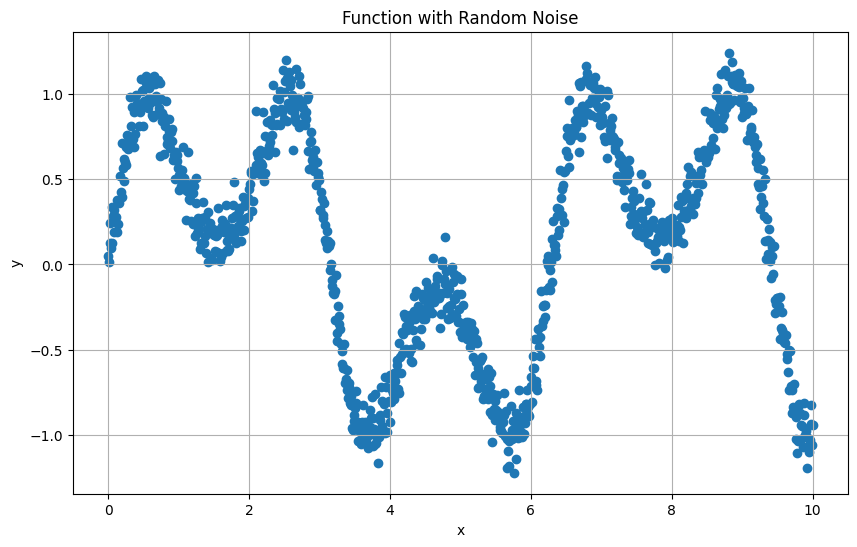

Epochs 5000  train loss 0.21633309125900269
Epochs 10000 train loss 0.10856582224369049
Epochs 15000 train loss 0.10091646015644073
Epochs 20000 train loss 0.08640065044164658
Epochs 25000 train loss 0.06659527868032455
Epochs 30000 train loss 0.056370802223682404
Epochs 35000 train loss 0.04599056765437126
Epochs 40000 train loss 0.03254883363842964
Epochs 45000 train loss 0.022771203890442848
Epochs 50000 train loss 0.017399046570062637
Time consumption training: 146.03810286521912 sec


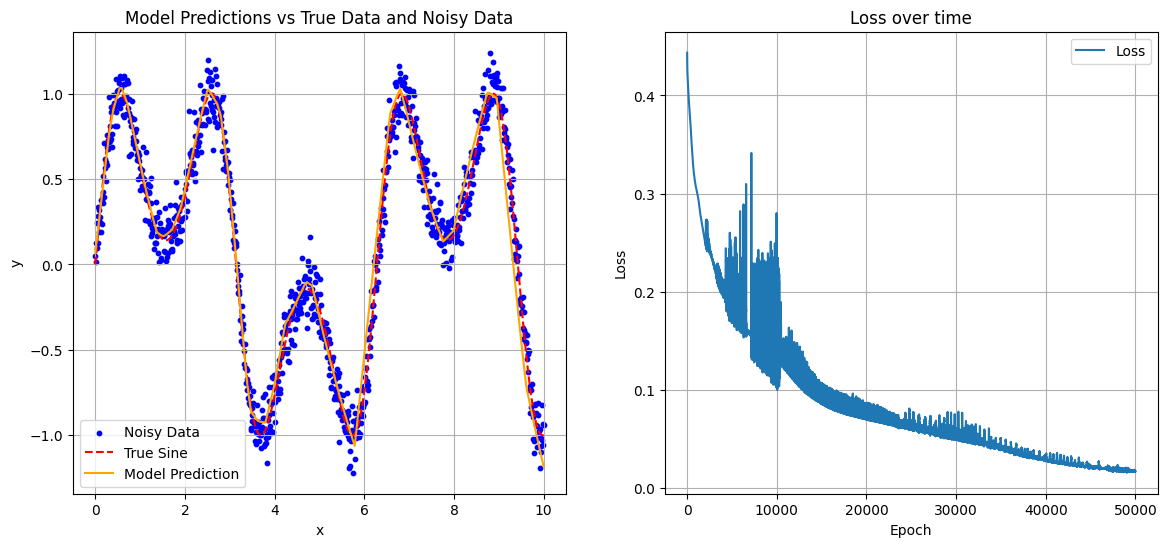

In [64]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Functions
def generate_points(start=0.0, end=10.0, size=1000):
    x_values = np.linspace(start, end, size)
    y_values = np.sin(3*np.sin(x_values))
    np.random.seed(42)
    noise = 0.1 * np.random.randn(len(x_values))
    noisy_y_values = y_values + noise
    return (x_values, noisy_y_values)

def plot_result(X, y, model, loss):
    x_values, noisy_y_values = X, y
    x_values = np.array(x_values).reshape(-1, 1)
    noisy_y_values = np.array(noisy_y_values)
    y_values = np.sin(3*np.sin(x_values)).flatten()
    x_t = torch.tensor(x_values, dtype=torch.float32)
    predicted_y_values = model(x_t).flatten()

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(x_values, noisy_y_values, label='Noisy Data', color='blue', s=10)
    plt.plot(x_values, y_values, label='True Sine', color='red', linestyle='--')
    plt.plot(x_values, predicted_y_values.detach().numpy(), label='Model Prediction', color='orange')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Model Predictions vs True Data and Noisy Data')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Loss')
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def simple_graph(X, y):
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y)
    plt.title("Function with Random Noise")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

# Sine's random data
X, y = generate_points()
simple_graph(X, y)

class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=1):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128), 
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)  # Output Layer
        )

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
lr = 10e-3 # <--
num_epochs = 50000 # <--

# Convert to PyTorch tensors
X_tensor = torch.from_numpy(X).float().view(-1, 1)
y_tensor = torch.from_numpy(y).float().view(-1, 1)

# Init model
model = Net()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

n_show_loss = num_epochs // 10
training_loss = []
t_0 = time.time()
model.train(True)
# Begin training loop
for epoch in range(num_epochs):
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    training_loss.append(loss.item())
    if ((epoch+1) % n_show_loss == 0) or (epoch == num_epochs-1):
        print(f"Epochs {epoch+1}".ljust(12), f"train loss {loss.item()}")

t_end = time.time()-t_0
print(f"Time consumption training: {t_end} sec")

plot_result(X, y, model, training_loss)